# **California District Housing Values: Model Building**

## **About the data**

### Data collection

Median house prices for *California districts* derived from the 1990 census.  The [dataset](https://www.kaggle.com/datasets/harrywang/housing?resource=download), derived from research by ***Pace, R. Kelley, and Ronald Barry in their 1997 paper "Sparse Spatial Autoregressions,"*** offers a historical lens through which we can understand and project housing market trends. Each observation represents a block group—a small geographical unit that serves as the foundation for building a model with significant practical applications. The block group can be defined as a district for easier interpretation.

### Feature Information

1. **longitude**: A measure of how far west a house is; a higher value is farther west

2. **latitude**: A measure of how far north a house is; a higher value is farther north

3. **housingMedianAge**: Median age of a house within a block; a lower number is a newer building

4. **totalRooms**: Total number of rooms within a block

5. **totalBedrooms**: Total number of bedrooms within a block

6. **population**: Total number of people residing within a block

7. **households**: Total number of households, a group of people residing within a home unit, for a block

8. **medianIncome**: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. **medianHouseValue** ***(Target Variable)***: Median house value for households within a block (measured in US Dollars)

10. **oceanProximity**: Location of the house w.r.t ocean/sea. They have the following five categories: 'NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN' and 'ISLAND'.

### Import Useful Libraries and data

In [1]:
# data manipulation and numerical calculations
import pandas as pd
import numpy as np

pd.set_option("display.width", 150)  # set output width for dataframes
import random as rnd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read dataset
housing_data = pd.read_csv("data/housing.csv")

In [3]:
# train-test split
from sklearn.model_selection import train_test_split

In [4]:
train_df, test_df = train_test_split(housing_data, test_size=0.2, random_state=42)

In [5]:
print(
    f"The training data of independent contains {train_df.shape[0]} observations and {train_df.shape[1]} variables"
)
print(
    f"The testing data contains {test_df.shape[0]} observations and {test_df.shape[1]} variables"
)

The training data of independent contains 16512 observations and 10 variables
The testing data contains 4128 observations and 10 variables


In [6]:
# Separate features for easier use in analysis
numerical_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_bedrooms",
    "total_rooms",
    "population",
    "households",
    "median_income",
]
categorical_features = ["ocean_proximity"]
target = "median_house_value"

## Feature Engineering

As each observation of the housing data denotes a single district of california, we can do feature engineering for more meaningful features.

The following features could be engineered:
1. **Longitude** & **Latitude**
   - **Interaction Term**: Create an interaction term between *longitude* and *latitude* to capture any combined effect on housing prices.
2. **Median Housing Age**
    - Binning: Bin the housing median age into categories (e.g., *new, moderate, old*) to capture non-linear relationships.
    - Interaction Terms: Interact *median_housing_age* with *median_income* and *ocean_proximity* to see if the age of houses in different income - brackets or proximity to the ocean affects the prices differently.
3. **Total Rooms** & **Total Bedrooms**
    - **Rooms per Household**: The average number of rooms per household. This might better reflect the living conditions and available space, which could influence housing prices.
    - **Bedrooms per Room**: Ratio of bedrooms to total rooms, reflecting the typical size and layout of homes in the block.
    - **Interaction with Population**: Create an interaction feature between *total_rooms* and *population* to understand if denser populations with more rooms have an impact on prices.
4. **Population**
   - **Population per Household**: Capture the average number of people per household, which might indicate crowding and influence pricing.
5. **Median Income**
   - **Interaction Terms**: Interact *median_income* with *median_housing_age* and *ocean_proximity*  to explore if income levels in combination with house age or proximity to the ocean influence house values differently.
6. **Ocean Proximity**
   - **Interaction with Latitude/Longitude**: Interact *ocean_proximity* with *longitude* and *latitude* to capture the specific effects of location relative to the ocean.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
# Custom transformer for creating interaction terms and additional features
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # TODO: engineer other features with analysis
        # # Create interaction terms
        # X['longitude_latitude_interaction'] = X['longitude'] * X['latitude']

        # # Binning housing median age
        # bins = [0, 20, 40, np.inf]
        # labels = ['new', 'moderate', 'old']
        # X['housingMedianAge_binned'] = pd.cut(X['housingMedianAge'], bins=bins, labels=labels)

        # # Interaction terms
        # X['age_income_interaction'] = X['housingMedianAge'] * X['medianIncome']
        # X['age_ocean_interaction'] = X['housingMedianAge'].astype(str) + "_" + X['oceanProximity']

        # Rooms per Household and Bedrooms per Room
        X["rooms_per_household"] = X["total_rooms"] / X["households"]
        X["bedrooms_per_rooms"] = X["total_bedrooms"] / X["total_rooms"]
        X["bedrooms_per_households"] = X["total_bedrooms"] / X["households"]
        # X['rooms_population_interaction'] = X['totalRooms'] * X['population']

        # Population per Household
        X["population_per_household"] = X["population"] / X["households"]

        # # Interaction with Ocean Proximity
        # X['ocean_longitude_interaction'] = X['longitude'].astype(str) + "_" + X['oceanProximity']
        # X['ocean_latitude_interaction'] = X['latitude'].astype(str) + "_" + X['oceanProximity']

        return X

In [9]:
# apply feature engineering
feat_engineer = FeatureEngineering()
engineered_df = feat_engineer.fit_transform(train_df)

#### **Understanding the data**

In [10]:
print(
    f"The data contains {engineered_df.shape[0]} rows and {engineered_df.shape[1]} columns"
)
print(
    f"The data contains {engineered_df.shape[1] - train_df.shape[1]} more columns after feature engineering"
)

The data contains 16512 rows and 14 columns
The data contains 4 more columns after feature engineering


In [11]:
engineered_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_rooms,bedrooms_per_households,population_per_household
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,5.017657,0.200576,1.006421,3.691814
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,4.473545,0.232703,1.041005,1.738095
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,5.645833,0.174486,0.985119,2.723214
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,4.002817,0.258269,1.033803,3.994366
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,6.268421,0.180940,1.134211,2.300000


In [12]:
engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   ocean_proximity           16512 non-null  object 
 10  rooms_per_household       16512 non-null  float64
 11  bedrooms_per_rooms        16512 non-null  float64
 12  bedrooms_per_households   16512 non-null  float64
 13  population_per_household  16512 non-null  float64
dtypes: floa

> **Observations:**
> 1. Categorical Variables: *ocean_proximity* is the only variable of dtype 'object'
> 2. Numerical Variables: All other variables are numerical of dtype 'float64'

#### **Duplication Check**

In [13]:
engineered_df.nunique()[-4:]

rooms_per_household         15671
bedrooms_per_rooms          15731
bedrooms_per_households     11949
population_per_household    15297
dtype: int64

In [14]:
print("The Categories for ocean_proximity are:")
classes = engineered_df["ocean_proximity"].unique()
print(classes)

The Categories for ocean_proximity are:
['NEAR OCEAN' 'INLAND' '<1H OCEAN' 'NEAR BAY' 'ISLAND']


> **Observations:**
> * High amount of unique values for the numerical variables.
> * 5 categories for ocean_proximity

#### **Missing values Calculations**

In [15]:
engineered_df.isnull().sum()[-4:]

rooms_per_household         0
bedrooms_per_rooms          0
bedrooms_per_households     0
population_per_household    0
dtype: int64

> **Observation:** There are no missing values in the training data. There could be some in the testing data and should be accounted for in the preprocessing pipelines using imputation

### EDA

In [16]:
# Separate features for easier use in analysis
numerical_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_bedrooms",
    "total_rooms",
    "population",
    "households",
    "median_income",
]
engineered_features = [
    "rooms_per_household",
    "bedrooms_per_rooms",
    "bedrooms_per_households",
    "population_per_household",
]
categorical_features = ["ocean_proximity"]
target = "median_house_value"

#### Summary Statistics

In [17]:
summary = engineered_df.drop(columns=target, axis=1).describe().T
summary["range"] = summary["max"] - summary["min"]
summary[-4:]

,count,mean,std,min,25%,50%,75%,max,range
rooms_per_household,16512.0,5.435235,2.387375,0.888889,4.452055,5.235874,6.061037,141.909091,141.020202
bedrooms_per_rooms,16512.0,0.212858,0.057995,0.100000,0.175178,0.202808,0.239501,1.000000,0.900000
bedrooms_per_households,16512.0,1.096685,0.433215,0.333333,1.006508,1.049286,1.100348,25.636364,25.303030
population_per_household,16512.0,3.096961,11.578744,0.692308,2.428799,2.817240,3.280000,1243.333333,1242.641026


> **Observations:**
> 
> 1. On average, the **housing_median_age** in a district is ~28 with ~12 standard deviation. There potentially might be outliers.
> 2. On average, the **total rooms** in a district are ~2.6k with high standard deviation. The range shows a huge difference between min and max as max values show ~39k shows the presence of outliers. The distibution might be right skewed.
> 3. On average, the **total bedrooms** in a district  are ~0.5k with high standard deviation. The range shows a huge difference between min and max as max values show ~5k shows the presence of outliers. The distibution might be right skewed.
> 4. On average, the **households** in a district  are ~0.5k with high standard deviation. The range shows a huge difference between min and max as max values show ~6k shows the presence of outliers. The distibution might be right skewed.
> 5. On average, the **populations** in a district  are ~1.4k with high standard deviation. The range shows a huge difference between min and max as max values show ~35k shows the presence of outliers. The distibution might be right skewed.
> 6. On average, the **median_income** in a district is ~3.8 (in 10,000 USD) with ~1.9 (in 10,000 USD) standard deviation. The range shows a huge difference between min and max as max values show ~14.5 (in 10,000 USD) shows the presence of outliers. The distibution might be right skewed.

Skewed distributions and outliers can be accomodated for modelling through the following ways:
- Remove few outliers.
- Apply log transformation for getting approximately normal distribution. Be aware of zero values in the skewed features.
- Apply scaling for reducing the influence of certain features in the prediction model.

<!--  -->

#### Univariate Analysis

##### Numerical Features

In [18]:
def plot_univars(df, num_cols, nbins):
    """
    Plots histogram and boxplot of the counts of the variables

    Args:
        df (Dataframe): dataframe containing the variables
        cols (List[str]): List of string of column names to be plotted
        nbins (int): The number of bins in histogram

    Returns: None
    """
    for col in num_cols:
        print(
            f"Measure of skewnesss for {col} : {round(df[col].skew(), 3)}"
        )  # Calculate skewness
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=nbins)  # Histogram for univariate counts
        plt.ylabel("count")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])  # Boxplot for univariate counts

        plt.show()

Measure of skewnesss for rooms_per_household : 18.607


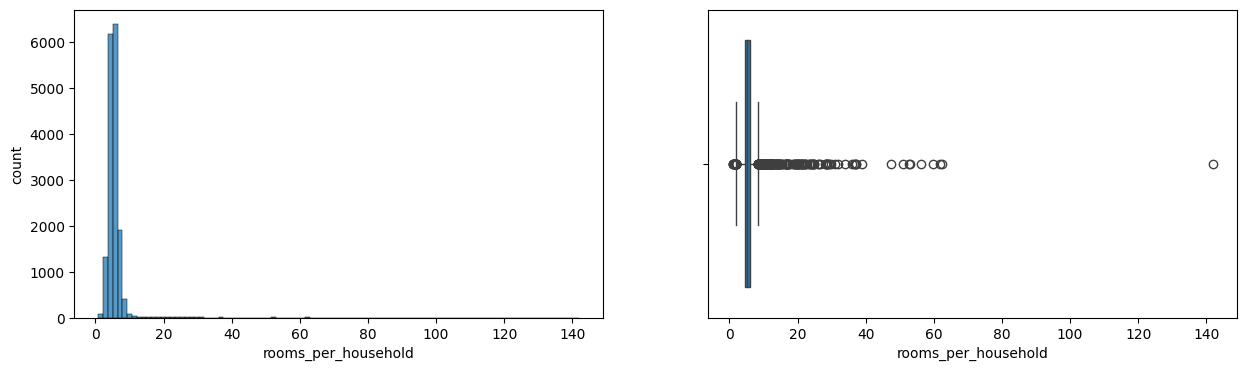

Measure of skewnesss for bedrooms_per_rooms : 2.245


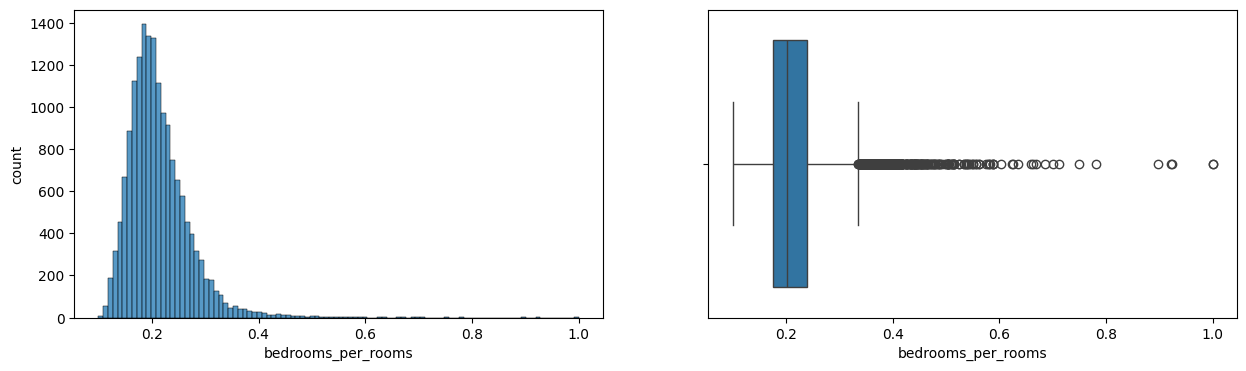

Measure of skewnesss for bedrooms_per_households : 23.171


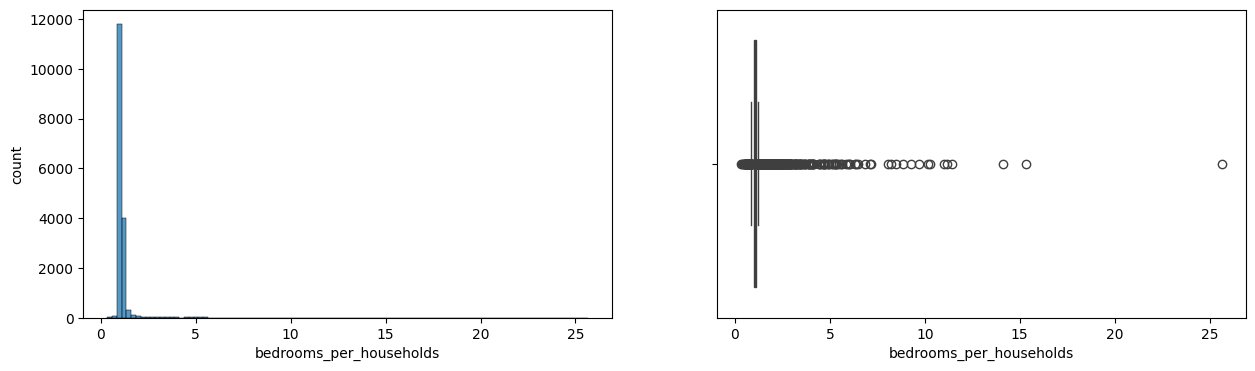

Measure of skewnesss for population_per_household : 88.053


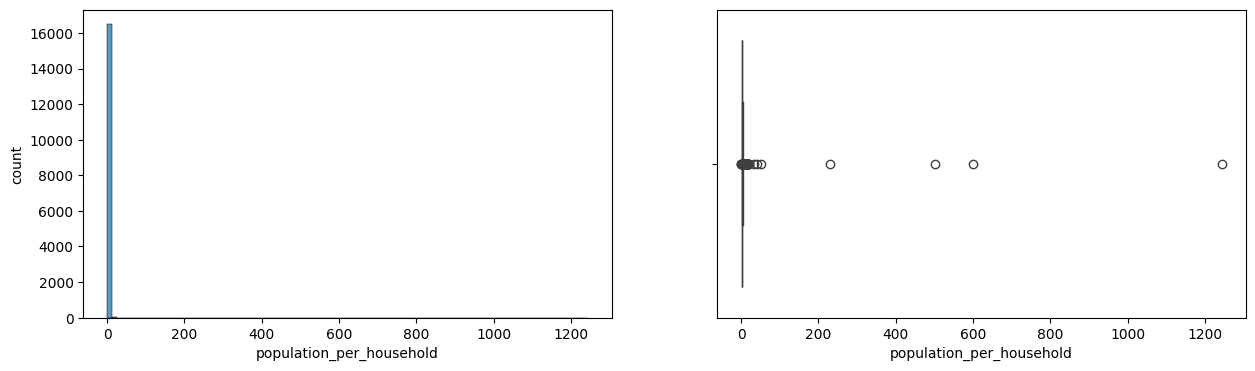

In [19]:
plot_univars(engineered_df, engineered_features, 100)

> **Observations:**
> 1. The distribution for **latitude** shows two peaks with no outliers. 
> 2. The distribution for **longitude** shows multiple peaks with no outliers. 
> 3. The distribution for **housing median age** also has mulitple peaks with no outliers.
> 4. The distribution for total number of **bedrooms** is right skewed with significant number of outliers.
> 5. The distribution for total number of **rooms** is right skewed with significant number of outliers.
> 6. The distribution for **population** in each district is right skewed with significant number of outliers.
> 7. The distribution for number of **households** in each district is right skewed with significant number of outliers.

The multiple peaks can be resolved in the one or more of the following ways:
- Transform data using log or square root function to minimize the impact of multiple peaks.
- Converting the continous features into categorical bins or ranges.
- Clustering the values using clustering algorithms or converting into separate gaussian distributions.
- Using ensembling models for handling complex data.

The skewness can be handled by introducing log, square root or quantile transformation of the skewed distribution.

<!--  -->

#### Bivariate Analysis - Interaction with Target Variable

##### Numerical Columns

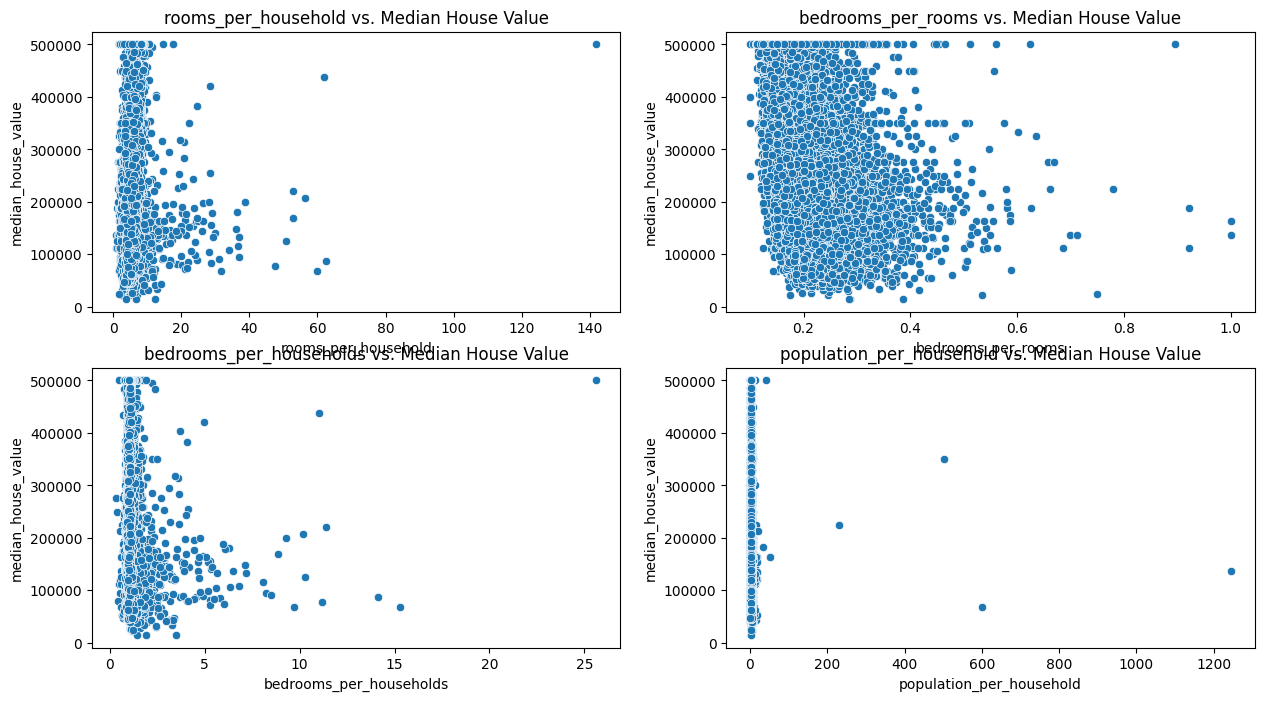

In [20]:
# Check for the relationship between the numerical columns and the target variable
plt.figure(figsize=(15, 8))
for i, feature in enumerate(engineered_features, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=engineered_df, x=feature, y=target)
    plt.title(f"{feature} vs. Median House Value")
plt.show()

In [21]:
corr_matrix = engineered_df.drop(columns=categorical_features, axis=1).corr()
corr_matrix[target][-4:]

rooms_per_household         0.158485
bedrooms_per_rooms         -0.257419
bedrooms_per_households    -0.051351
population_per_household   -0.022030
Name: median_house_value, dtype: float64

**Observations for feature relationship with target variable:**
1. The data points are densily located in the lower values for the visualized variables. The values are the almost uniformly distributed over the target variable.

Resolving non-linear relationships in one or more of the following ways:
- Removing irrelvant features using feature selection or engineer features.
- Cluster or binning the features that are densely populated at some values.
- Use ensemble models like bagging and boosting models to capture non-linear relationships
- Feature selection can be done through LASSO regression models or exhaustive selection algorithms.

<!--  -->

#### Mutivariate Analysis

##### Numerical features : Collinearity

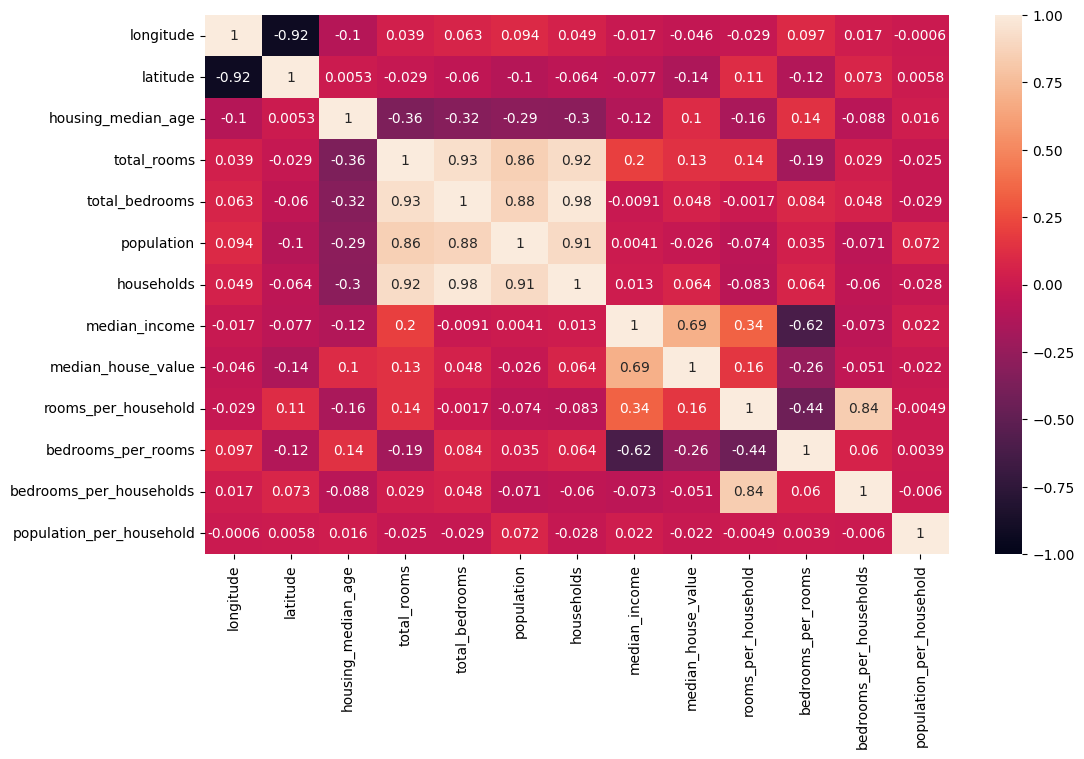

In [22]:
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.show()

In [23]:
# Function to identify highly correlated features
def get_highly_correlated_features(corr_matrix, threshold):
    highly_correlated = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                highly_correlated.append(
                    (
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        round(corr_matrix.iloc[i, j], 3),
                    )
                )
    return highly_correlated, threshold

In [24]:
# Identify highly correlated features with a threshold
highly_correlated_features, threshold = get_highly_correlated_features(
    corr_matrix, threshold=0.8
)
multi_collineary = pd.DataFrame(
    highly_correlated_features, columns=["Feature1", "Feature2", "Threshold"]
)
print(f"Highly Correlated Features with threshold value greater than {threshold}:")
print(multi_collineary)

Highly Correlated Features with threshold value greater than 0.8:
                  Feature1             Feature2  Threshold
0                 latitude            longitude     -0.924
1           total_bedrooms          total_rooms      0.930
2               population          total_rooms      0.858
3               population       total_bedrooms      0.879
4               households          total_rooms      0.920
5               households       total_bedrooms      0.980
6               households           population      0.907
7  bedrooms_per_households  rooms_per_household      0.836


> **Observations:**
> 1. The above listed feature pairs are above the listed  threshold values.

The high collinearity can be resolved in the following ways:
- Feature engineering by combining the highly correleated features.
- Reducing the dimesionality of the data and transforming features into uncorrelated features through PCA.
- use Regularization techniques like LASSO or Ridge  regression to reduce the effect of highly correlated features.
- Dropping the highly correlated features or apply feature selection.

## Data transformation

Transform all highly skewed variables.

In [25]:
log_features = [
    "total_bedrooms",
    "total_rooms",
    "population",
    "households",
    "rooms_per_household",
    "bedrooms_per_rooms",
    "bedrooms_per_households",
    "population_per_household",
]

In [26]:
# Function for log transformation of the column
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()  # Create a copy to avoid altering the original data
        for colname in self.columns:
            if (X[colname] == 1.0).all():
                X[colname] = np.log(X[colname] + 1)
            else:
                X[colname] = np.log(X[colname])
        return X

In [27]:
transformer = LogTransformer(columns=log_features)
transformed_df = transformer.fit_transform(engineered_df)

#### **Understanding the data**

In [28]:
print(
    f"The data contains {transformed_df.shape[0]} rows and {transformed_df.shape[1]} columns"
)
print(
    f"The data contains {engineered_df.shape[1] - transformed_df.shape[1]} more columns after log transformation"
)

The data contains 16512 rows and 14 columns
The data contains 0 more columns after log transformation


In [29]:
transformed_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_rooms,bedrooms_per_households,population_per_household
14196,-117.03,32.71,33.0,8.047510,6.440947,7.740664,6.434547,3.2596,103000.0,NEAR OCEAN,1.612963,-1.606563,0.006400,1.306118
8267,-118.16,33.77,49.0,8.126223,6.668228,7.180831,6.628041,3.8125,382100.0,NEAR OCEAN,1.498181,-1.457994,0.040187,0.552790
17445,-120.48,34.66,4.0,7.548029,5.802118,6.818924,5.817111,4.1563,172600.0,NEAR OCEAN,1.730918,-1.745911,-0.014993,1.001813
14265,-117.11,32.69,36.0,7.259116,5.905362,7.257003,5.872118,1.9425,93400.0,NEAR OCEAN,1.386998,-1.353754,0.033244,1.384885
2271,-119.80,36.78,43.0,7.775696,6.066108,6.773080,5.940171,3.5542,96500.0,INLAND,1.835524,-1.709588,0.125937,0.832909


In [30]:
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 14196 to 15795
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16512 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   median_house_value        16512 non-null  float64
 9   ocean_proximity           16512 non-null  object 
 10  rooms_per_household       16512 non-null  float64
 11  bedrooms_per_rooms        16512 non-null  float64
 12  bedrooms_per_households   16512 non-null  float64
 13  population_per_household  16512 non-null  float64
dtypes: floa

> **Observations:**
> 1. Categorical Variables: *ocean_proximity* is the only variable of dtype 'object'
> 2. Numerical Variables: All other variables are numerical of dtype 'float64'

#### **Duplication Check**

In [31]:
transformed_df.nunique()

longitude                     833
latitude                      845
housing_median_age             52
total_rooms                  5470
total_bedrooms               1816
population                   3639
households                   1706
median_income               10932
median_house_value           3675
ocean_proximity                 5
rooms_per_household         15671
bedrooms_per_rooms          15731
bedrooms_per_households     11949
population_per_household    15297
dtype: int64

> **Observations:**
> * High amount of unique values for the numerical variables.
> * 5 categories for ocean_proximity

#### **Missing values Calculations**

In [32]:
transformed_df.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
ocean_proximity             0
rooms_per_household         0
bedrooms_per_rooms          0
bedrooms_per_households     0
population_per_household    0
dtype: int64

> **Observation:** There are no missing values in the training data. There could be some in the testing data and should be accounted for in the preprocessing pipelines using imputation

### EDA

#### Summary Statistics

In [33]:
summary = transformed_df.drop(columns=[target], axis=1).describe().T
summary["range"] = summary["max"] - summary["min"]
summary

,count,mean,std,min,25%,50%,75%,max,range
longitude,16512.0,-119.582290,2.005654,-124.350000,-121.810000,-118.510000,-118.010000,-114.310000,10.040000
latitude,16512.0,35.643149,2.136665,32.550000,33.930000,34.260000,37.720000,41.950000,9.400000
housing_median_age,16512.0,28.608285,12.602499,1.000000,18.000000,29.000000,37.000000,52.000000,51.000000
total_rooms,16512.0,7.631864,0.750354,0.693147,7.282074,7.663408,8.058327,10.579489,9.886341
total_bedrooms,16512.0,6.053290,0.731187,0.000000,5.692889,6.079933,6.472346,8.771060,8.771060
population,16512.0,7.025458,0.737016,1.098612,6.670766,7.062192,7.453562,10.482402,9.383789
households,16512.0,5.982475,0.732085,0.000000,5.634790,6.016157,6.406880,8.713089,8.713089
median_income,16512.0,3.880754,1.904294,0.499900,2.566700,3.545800,4.773175,15.000100,14.500200
rooms_per_household,16512.0,1.649389,0.274355,-0.117783,1.493366,1.655534,1.801881,4.955187,5.072970
bedrooms_per_rooms,16512.0,-1.578574,0.244538,-2.302585,-1.741954,-1.595497,-1.429196,0.000000,2.302585


<!--  -->

#### Univariate Analysis

##### Log transformed Features

In [34]:
def plot_log_transformed(df, num_cols, nbins):
    for col in num_cols:
        print(col)
        print("Skew :", round(df[col].skew(), 2))  # Calculate skewness
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=nbins)
        # Density plot for log transformed features
        plt.ylabel("count")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])  # Boxplot for univariate counts
        plt.show()

total_bedrooms
Skew : -1.05


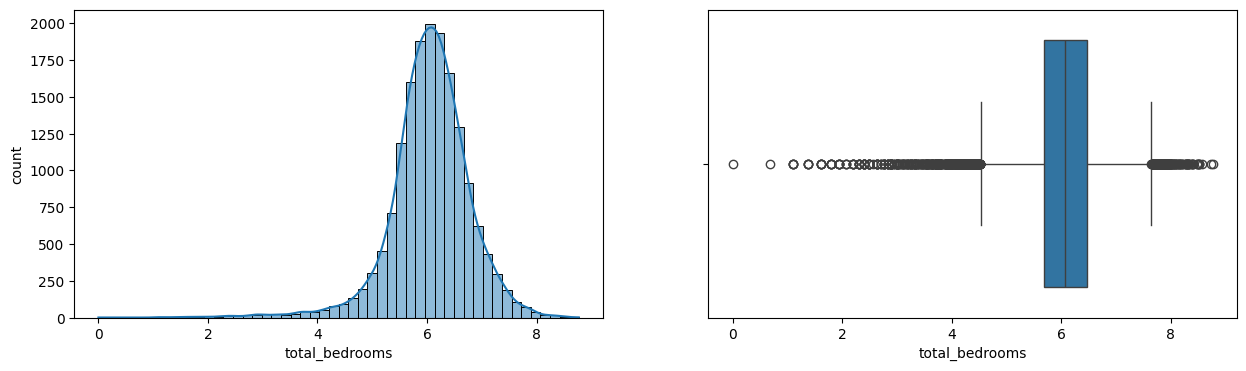

total_rooms
Skew : -1.09


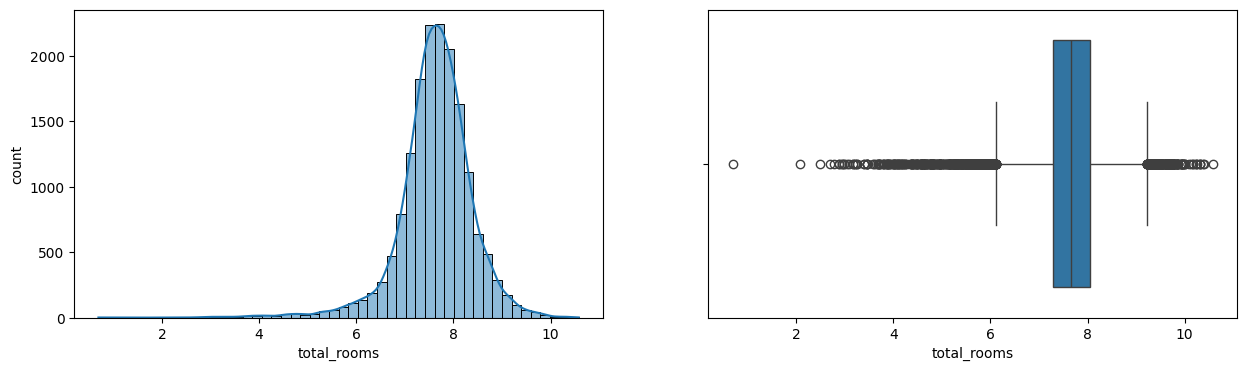

population
Skew : -1.06


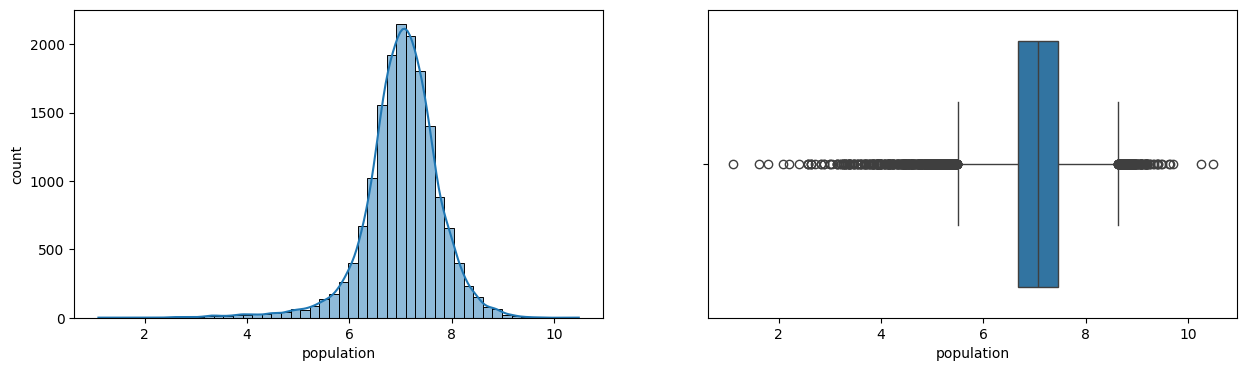

households
Skew : -1.12


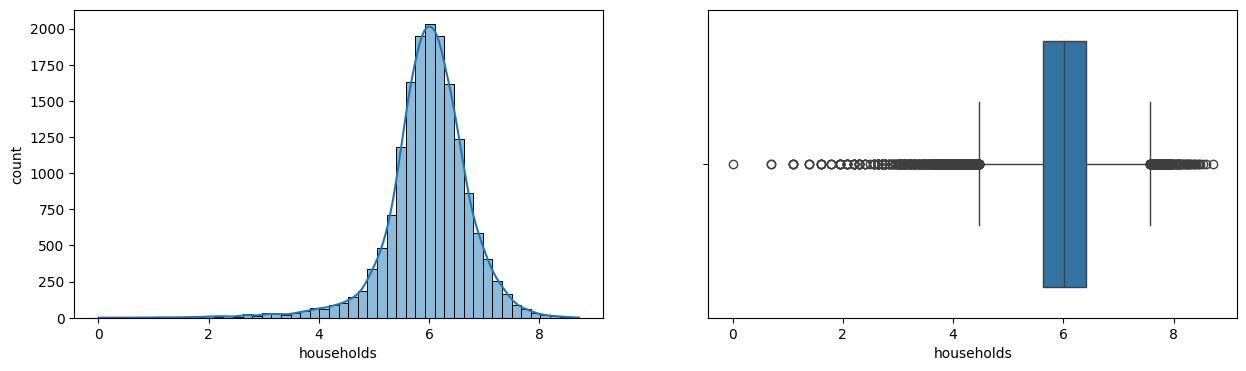

rooms_per_household
Skew : 0.83


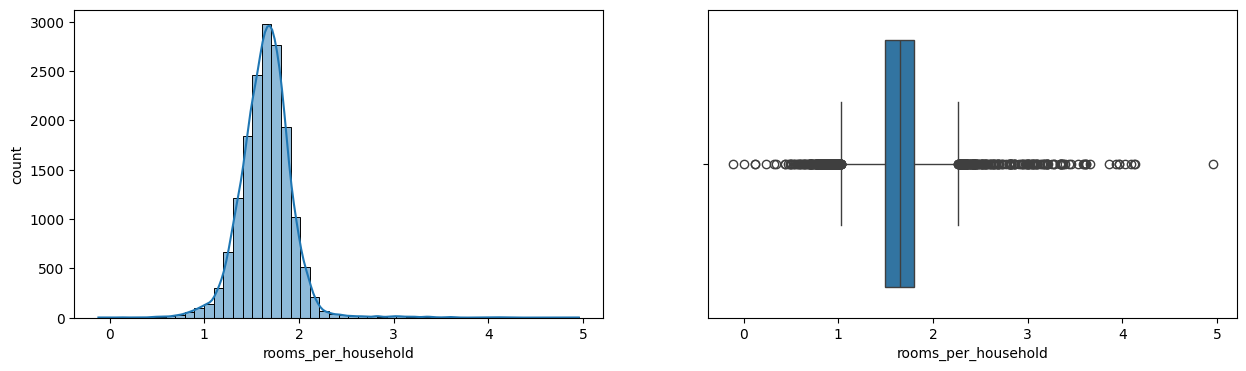

bedrooms_per_rooms
Skew : 0.54


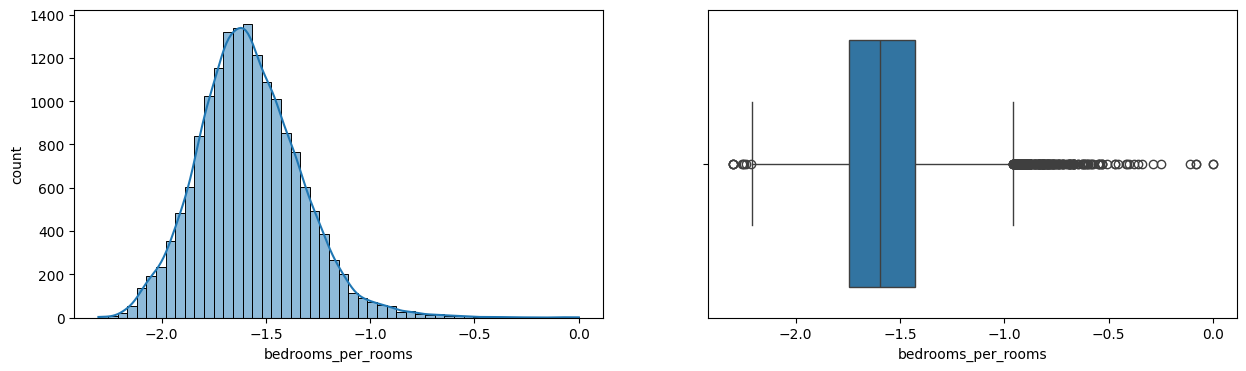

bedrooms_per_households
Skew : 6.23


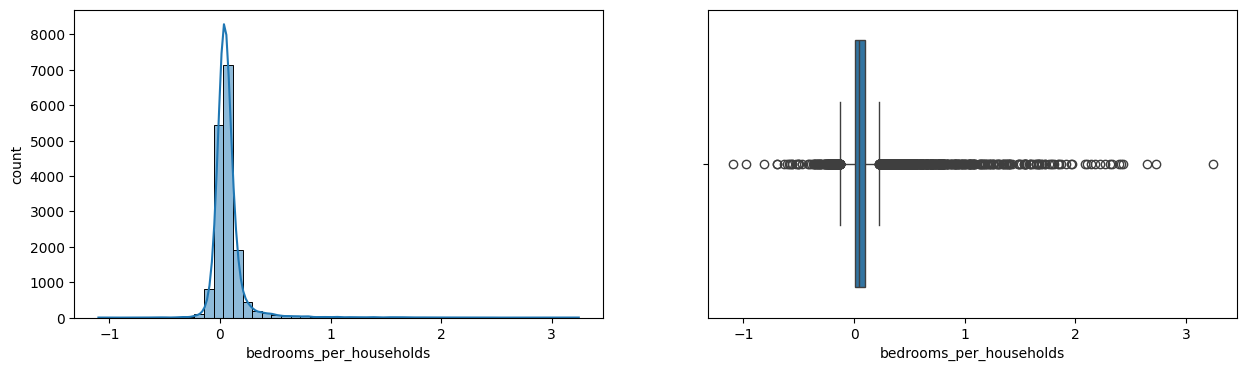

population_per_household
Skew : 2.35


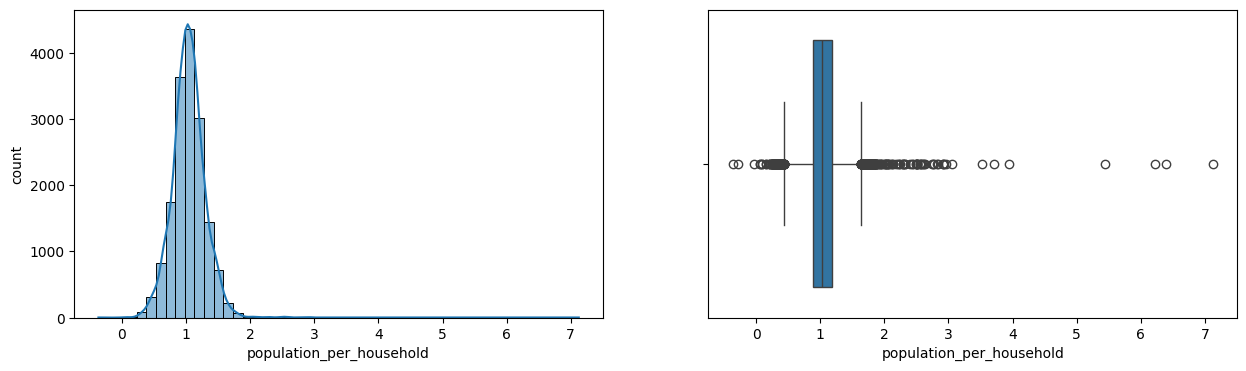

In [35]:
plot_log_transformed(transformed_df, log_features, 50)

> **Observations:**
> 1. All skewed distributions are resolved

The outliers can be resolved in the one or more of the following ways:
- Remove outliers
- Perform robust scaling (robus scaling is more sensitive to outliers)

<!--  -->

#### Bivariate Analysis - Interaction with Target Variable

##### Numerical Columns

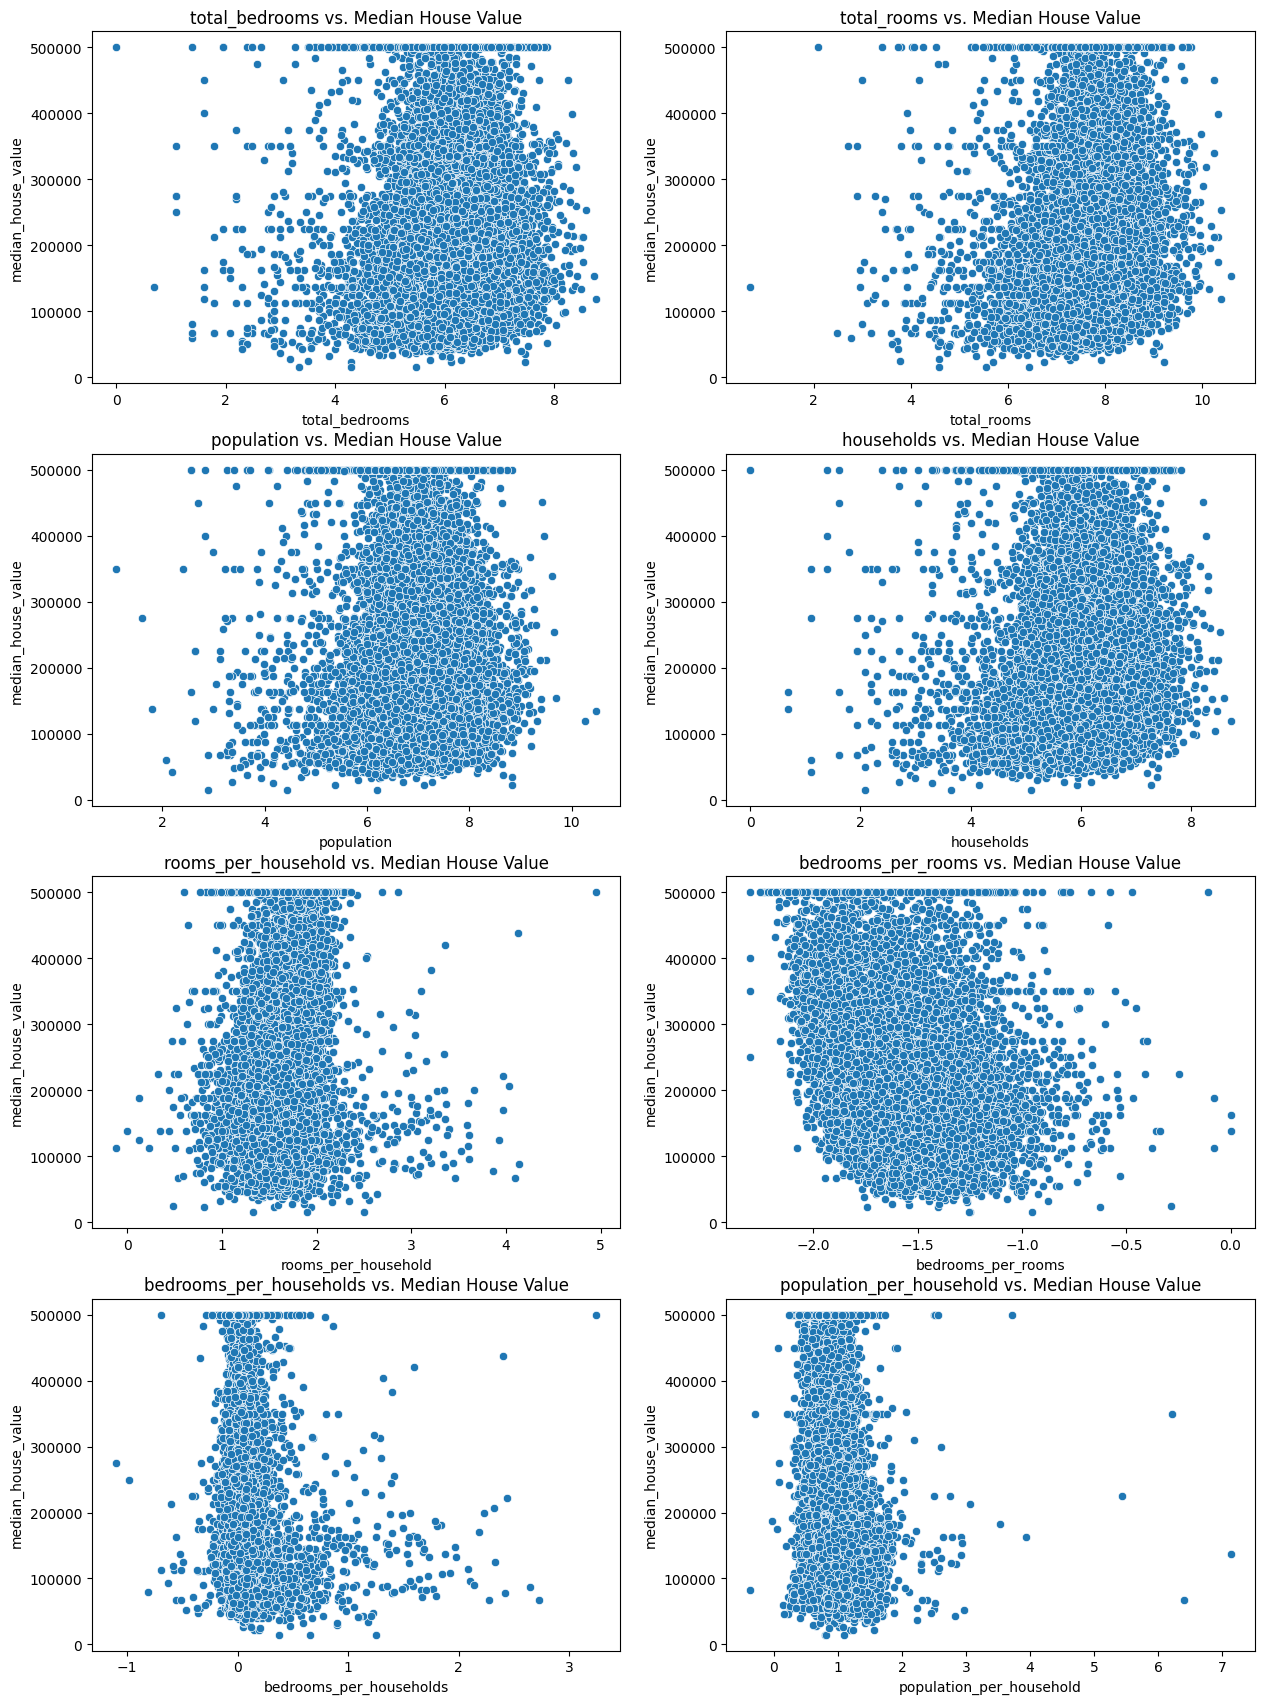

In [36]:
# Check for the relationship between the numerical columns and the target variable
plt.figure(figsize=(15, 32))
for i, feature in enumerate(log_features, 1):
    plt.subplot(6, 2, i)
    sns.scatterplot(data=transformed_df, x=feature, y=target)
    plt.title(f"{feature} vs. Median House Value")
plt.show()

In [37]:
corr_matrix = transformed_df.drop(columns=categorical_features, axis=1).corr()
corr_matrix[target]

longitude                  -0.046349
latitude                   -0.142983
housing_median_age          0.103706
total_rooms                 0.157375
total_bedrooms              0.051287
population                 -0.023165
households                  0.071335
median_income               0.690647
median_house_value          1.000000
rooms_per_household         0.240066
bedrooms_per_rooms         -0.329546
bedrooms_per_households    -0.089232
population_per_household   -0.253849
Name: median_house_value, dtype: float64

**Observations for feature relationship with target variable:**
1. There is no clear linear association with **longitude** or **latitude**. The values seem densly populated in around the values of -122 & -118 for longitude, and 34 & 38 for latitude.
2. There is no linear association with **median house age**. They seem independent to each other as the data points are uniformly distibuted all over the scatterplot.
3. The data points are densily located in the lower values for the following features - **total_bedrooms, total_rooms, households** and **population**. The values are the almost uniformly distributed over the target variable.
4. There is a positive linear association with **median income**.

Resolving non-linear relationships in one or more of the following ways:
- Removing irrelvant features using feature selection or engineer features.
- Cluster or binning the features that are densely populated at some values.
- Use ensemble models like bagging and boosting models to capture non-linear relationships
- Feature selection can be done through LASSO regression models or exhaustive selection algorithms.

<!--  -->

#### Mutivariate Analysis

##### Numerical features : Collinearity

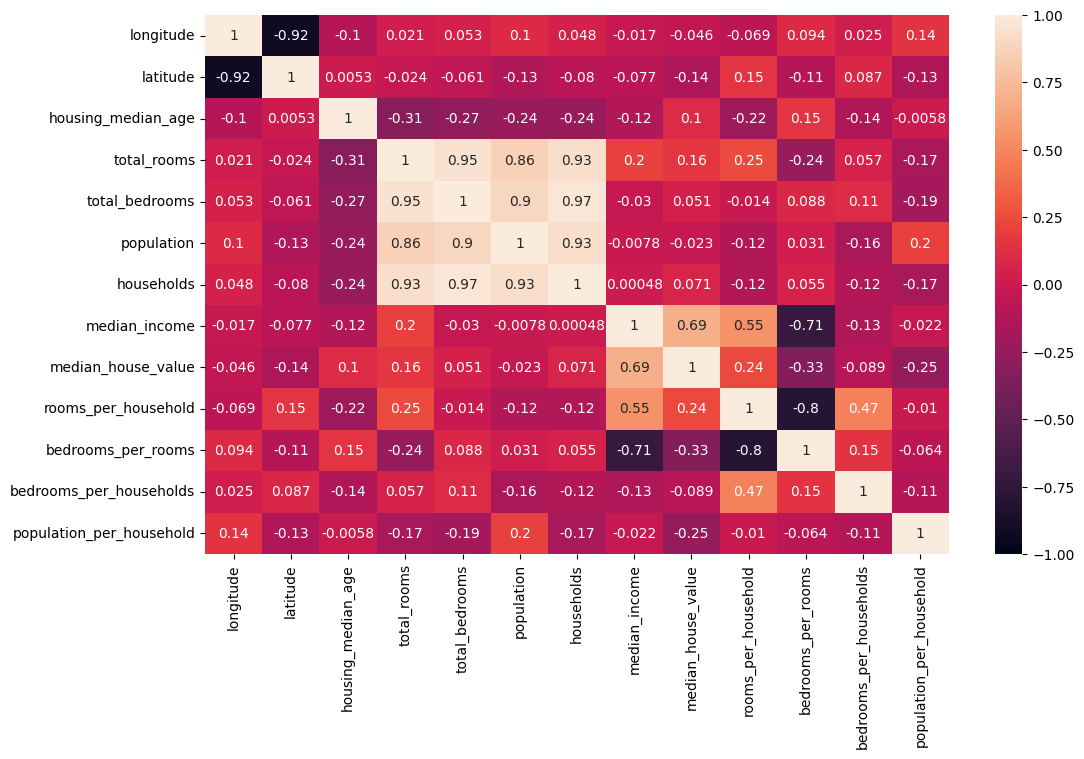

In [38]:
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1)
plt.show()

In [39]:
# Function to identify highly correlated features
def get_highly_correlated_features(corr_matrix, threshold):
    highly_correlated = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                highly_correlated.append(
                    (
                        corr_matrix.columns[i],
                        corr_matrix.columns[j],
                        round(corr_matrix.iloc[i, j], 3),
                    )
                )
    return highly_correlated, threshold

In [40]:
# Identify highly correlated features with a threshold
highly_correlated_features, threshold = get_highly_correlated_features(
    corr_matrix, threshold=0.8
)
multi_collineary = pd.DataFrame(
    highly_correlated_features, columns=["Feature1", "Feature2", "Threshold"]
)
print(f"Highly Correlated Features with threshold value greater than {threshold}:")
print(multi_collineary)

Highly Correlated Features with threshold value greater than 0.8:
             Feature1             Feature2  Threshold
0            latitude            longitude     -0.924
1      total_bedrooms          total_rooms      0.946
2          population          total_rooms      0.863
3          population       total_bedrooms      0.896
4          households          total_rooms      0.932
5          households       total_bedrooms      0.975
6          households           population      0.931
7  bedrooms_per_rooms  rooms_per_household     -0.804


> **Observations:**
> 1. The above listed feature pairs are above the listed  threshold values.

The high collinearity can be resolved in the following ways:
- Feature engineering by combining the highly correleated features.
- Reducing the dimesionality of the data and transforming features into uncorrelated features through PCA.
- use Regularization techniques like LASSO or Ridge  regression to reduce the effect of highly correlated features.
- Dropping the highly correlated features or apply feature selection.

## Model Building

### Data Preprocessing

#### Separating Features for easier access

In [41]:
numerical_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_bedrooms',
 'total_rooms',
 'population',
 'households',
 'median_income']

In [42]:
categorical_features

['ocean_proximity']

In [43]:
target

'median_house_value'

In [44]:
engineered_features

['rooms_per_household',
 'bedrooms_per_rooms',
 'bedrooms_per_households',
 'population_per_household']

In [45]:
log_features

['total_bedrooms',
 'total_rooms',
 'population',
 'households',
 'rooms_per_household',
 'bedrooms_per_rooms',
 'bedrooms_per_households',
 'population_per_household']

In [46]:
num_feats = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_rooms",
    "bedrooms_per_households",
    "population_per_household",
]

std_feats = ["latitude", "longitude", "housing_median_age"]

robust_feats = [
    "total_bedrooms",
    "total_rooms",
    "population",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_rooms",
    "bedrooms_per_households",
    "population_per_household",
]

assert set(num_feats + categorical_features + [target]) == set(transformed_df.columns)

assert set(numerical_features + categorical_features + [target]) == set(
    train_df.columns
)

#### Apply Feature Engineering and Data Transformation to Train & Test Data

In [47]:
# separate df into dependent and independent variables
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [48]:
# Model Selection
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [49]:
# Preprocessing data functions and Transformers
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

# Pipelines and Tranformers
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [50]:
# imputation preprocessor
imputer_processor = make_column_transformer(
    (SimpleImputer(strategy="median", fill_value="missing_values"), numerical_features),
    (
        SimpleImputer(strategy="most_frequent", fill_value="missing_values"),
        categorical_features,
    ),
)
imputer_processor

ColumnTransformer(transformers=[('simpleimputer-1',
                                 SimpleImputer(fill_value='missing_values',
                                               strategy='median'),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('simpleimputer-2',
                                 SimpleImputer(fill_value='missing_values',
                                               strategy='most_frequent'),
                                 ['ocean_proximity'])])

In [51]:
# perform imputation
imputed_X_train = pd.DataFrame(
    imputer_processor.fit_transform(X_train), columns=X_train.columns
)
imputed_X_test = pd.DataFrame(
    imputer_processor.transform(X_test), columns=X_train.columns
)

# Manually convert data types back to original
for column in numerical_features:
    imputed_X_train[column] = imputed_X_train[column].astype(
        float
    )  # or int, depending on your data
    imputed_X_test[column] = imputed_X_test[column].astype(
        float
    )  # or int, depending on your data

In [52]:
# apply feature endineering and data transformation to train and test data again
feat_engineer = FeatureEngineering()
transformer = LogTransformer(columns=log_features)

# perform feature engineering
engineered_X_train = feat_engineer.fit_transform(imputed_X_train)
engineered_X_test = feat_engineer.transform(imputed_X_test)

# perform log transformation
transformed_engineered_X_train = transformer.fit_transform(engineered_X_train)
transformed_engineered_X_test = transformer.transform(engineered_X_test)

#### Building Pipelines

In [53]:
# Make tranformers for each feature
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False), StandardScaler()
)

std_transformer = make_pipeline(StandardScaler())

robust_transformer = make_pipeline(RobustScaler())

In [54]:
# Make Preprocessor
preprocessor = make_column_transformer(
    (std_transformer, std_feats),
    (robust_transformer, robust_feats),
    (categorical_transformer, categorical_features),
)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['latitude', 'longitude',
                                  'housing_median_age']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income',
                                  'rooms_per_household', 'bedrooms_per_rooms',
                                  'bedrooms_per_households',
                                  'population_per_household']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['ocean_proximity'])])

In [55]:
# Apply transformations
final_X_train = pd.DataFrame(preprocessor.fit_transform(transformed_engineered_X_train))
# New Columns for OHE columns
new_cols = (
    transformed_engineered_X_train.columns.tolist()
    + preprocessor.named_transformers_["pipeline-3"].get_feature_names_out().tolist()
)
new_cols.remove("ocean_proximity")
new_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_rooms',
 'bedrooms_per_households',
 'population_per_household',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [56]:
final_X_train.columns = new_cols
final_X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_rooms,bedrooms_per_households,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-1.372811,1.272587,0.348490,0.494815,0.463160,0.866730,0.541892,-0.129709,-0.467912,0.035381,-0.137986,0.899862,-0.894683,-0.680574,-0.015566,-0.355646,2.629758
1,-0.876696,0.709162,1.618118,0.596216,0.754750,0.151559,0.792503,0.120872,-0.088879,-0.439646,-0.510032,-1.607500,-0.894683,-0.680574,-0.015566,-0.355646,2.629758
2,-0.460146,-0.447603,-1.952710,-0.148635,-0.356421,-0.310768,-0.257801,0.276686,-0.707905,0.480925,0.244345,-0.112981,-0.894683,-0.680574,-0.015566,-0.355646,2.629758
3,-1.382172,1.232698,0.586545,-0.520824,-0.223965,0.248866,-0.186558,-0.726634,-0.166766,-0.772939,-0.870412,1.162028,-0.894683,-0.680574,-0.015566,-0.355646,2.629758
4,0.532084,-0.108551,1.142008,0.144654,-0.017737,-0.369332,-0.098416,0.003807,0.873095,0.364788,0.583410,-0.675157,-0.894683,1.469348,-0.015566,-0.355646,-0.380263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,-0.872016,0.808883,0.507194,-0.606082,-0.996371,-0.731975,-0.824074,1.279960,-1.398952,0.940445,0.510520,0.244802,1.117714,-0.680574,-0.015566,-0.355646,-0.380263
16508,-0.759688,1.073144,0.348490,0.477389,0.340882,0.519794,0.117688,-0.224702,2.137142,0.296872,0.879782,1.086061,-0.894683,1.469348,-0.015566,-0.355646,-0.380263
16509,-0.755007,0.599469,0.586545,-0.017055,0.338629,0.521978,0.325148,-0.277094,0.320513,-0.924705,-0.883476,0.558621,1.117714,-0.680574,-0.015566,-0.355646,-0.380263
16510,0.906510,-1.185540,-1.079841,0.667711,0.400258,0.537165,0.401497,0.985010,0.198095,0.621266,0.648387,0.401984,1.117714,-0.680574,-0.015566,-0.355646,-0.380263


### Scoring Metric

In [57]:
# @title Change Scoring Metric
scoring_metric = "neg_mean_absolute_error"
# scoring_metric = "neg_mean_squared_error"
# scoring_metric = "r2"
# scoring_metric = "neg_root_mean_squared_error"

### Model Training

In [58]:
# Regression Models
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
    AdaBoostRegressor,
)

# from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [59]:
results_dict = {}  # dictionary to store all the results

In [60]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

##### Dummy

In [61]:
# Baseline model
dummy = DummyRegressor()
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, transformed_engineered_X_train, y_train, cv=5, return_train_score=True
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.021 (+/- 0.006),0.004 (+/- 0.000),-0.000 (+/- 0.000),0.000 (+/- 0.000)


#### Model Selection with Hyper-parameter Tuning

In [62]:
# Linear Regression hyperparameters
linear_params = {}

# Ridge Regression hyperparameters
ridge_params = {"ridge__alpha": [0.01, 0.1, 1.0, 10.0]}

# Decision Tree Regression hyperparameters
dt_params = {
    "decisiontreeregressor__max_depth": [None, 5, 10],
    "decisiontreeregressor__min_samples_split": [2, 5, 10],
    "decisiontreeregressor__min_samples_leaf": [1, 2, 4],
}

# Random Forest Regression hyperparameters
rf_params = {
    "randomforestregressor__n_estimators": [100, 200, 300],
    "randomforestregressor__max_depth": [None, 5, 10],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    "randomforestregressor__min_samples_leaf": [1, 2, 4],
    "randomforestregressor__max_features": ["sqrt", "log2"],
}

# # Support Vector Regression hyperparameters
# svr_params = {
#     'svr__C': [0.1, 1.0, 10.0],
#     "svr__gamma": [0.1, 1.0, 10],
#     'svr__kernel': ['linear', 'rbf'],
#     'svr__epsilon': [0.1, 0.2, 0.3]
# }

# Gradient Boosting Regression hyperparameters
gb_params = {
    "gradientboostingregressor__n_estimators": [100, 200, 300],
    "gradientboostingregressor__learning_rate": [0.01, 0.1, 1.0],
    "gradientboostingregressor__max_depth": [3, 5, 7],
    "gradientboostingregressor__subsample": [0.5, 0.8, 1.0],
}

# Bagging Regressor hyperparameters
bagging_params = {
    "baggingregressor__n_estimators": [10, 50, 100],
    "baggingregressor__max_samples": [0.5, 0.8, 1.0],
    "baggingregressor__max_features": [0.5, 0.8, 1.0],
    "baggingregressor__bootstrap": [True, False],
    "baggingregressor__bootstrap_features": [True, False],
}

# Adaboost Regressor hyperparameters
adaboost_params = {
    "adaboostregressor__n_estimators": [50, 100, 200],
    "adaboostregressor__learning_rate": [0.01, 0.1, 1],
    "adaboostregressor__loss": ["linear", "square", "exponential"],
}

# Catboost Regressor hyperparameters
# catboost_params = {
#     'catboostregressor__iterations': [100, 200, 500],
#     'catboostregressor__learning_rate': [0.01, 0.1, 0.3],
#     'catboostregressor__depth': [4, 6, 8, 10],
#     'catboostregressor__l2_leaf_reg': [1, 3, 5, 7],
#     'catboostregressor__border_count': [32, 64, 128]
# }

# XGBoost Regressor hyperparameters
xgb_params = {
    'xgbregressor__n_estimators': [100, 200, 500],
    "xgbregressor__learning_rate": [0.01, 0.1, 0.2],
    "xgbregressor__max_depth": [3, 5, 7, 9],
    "xgbregressor__min_child_weight": [1, 3, 5],
    "xgbregressor__gamma": [0, 0.1, 0.3],
    "xgbregressor__subsample": [0.8, 0.9, 1.0],
    "xgbregressor__colsample_bytree": [0.8, 0.9, 1.0],
    "xgbregressor__reg_alpha": [0, 0.01, 0.1],
    "xgbregressor__reg_lambda": [1, 1.5, 2],
}

In [63]:
# Create the regression pipelines
linear = make_pipeline(preprocessor, LinearRegression())
ridge = make_pipeline(preprocessor, Ridge())
dt = make_pipeline(preprocessor, DecisionTreeRegressor())
rf = make_pipeline(preprocessor, RandomForestRegressor())
# svr = make_pipeline(preprocessor, SVR())
bagging = make_pipeline(preprocessor, BaggingRegressor())
gb = make_pipeline(preprocessor, GradientBoostingRegressor())
# cat = make_pipeline(preprocessor, CatBoostRegressor())
ada = make_pipeline(preprocessor, AdaBoostRegressor())
xgb = make_pipeline(preprocessor, XGBRegressor())

In [64]:
# Make grid search objects
linear_GS = GridSearchCV(
    linear, linear_params, cv=5, n_jobs=-1, return_train_score=True
)
ridge_GS = GridSearchCV(ridge, ridge_params, cv=5, n_jobs=-1, return_train_score=True)
dt_GS = GridSearchCV(dt, dt_params, cv=5, n_jobs=-1, return_train_score=True)
rf_RS = RandomizedSearchCV(
    rf, rf_params, cv=5, n_jobs=-1, return_train_score=True, n_iter=2
)
# svr_RS = RandomizedSearchCV(
#     svr, svr_params, cv=5, n_jobs=-1, return_train_score=True, n_iter = 1
# )
bagging_RS = RandomizedSearchCV(
    bagging, bagging_params, cv=5, n_jobs=-1, return_train_score=True, n_iter=2
)
gb_RS = RandomizedSearchCV(
    gb, gb_params, cv=5, n_jobs=-1, return_train_score=True, n_iter=2
)
ada_RS = RandomizedSearchCV(
    ada, adaboost_params, cv=5, n_jobs=-1, return_train_score=True, n_iter=2
)
# cat_RS = RandomizedSearchCV(
#     cat, catboost_params, cv=5, n_jobs=-1, return_train_score=True, n_iter = 2
# )
xgb_RS = RandomizedSearchCV(
    xgb, xgb_params, cv=5, n_jobs=-1, return_train_score=True, n_iter=2
)

In [65]:
# CV results for Linear
linear_relevant = [
    "mean_test_score",
    "mean_train_score",
    "mean_fit_time",
    "rank_test_score",
]
linear_GS.fit(transformed_engineered_X_train, y_train)
linear_results = (
    pd.DataFrame(linear_GS.cv_results_)[linear_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
linear_results.T

rank_test_score,1
mean_test_score,0.672346
mean_train_score,0.673329
mean_fit_time,0.059949


##### Ridge

In [66]:
# CV results for Ridge
ridge_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_ridge__alpha",
    "mean_fit_time",
    "rank_test_score",
]
ridge_GS.fit(transformed_engineered_X_train, y_train)
ridge_results = (
    pd.DataFrame(ridge_GS.cv_results_)[ridge_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
ridge_results.T

rank_test_score,1,2,3,4
mean_test_score,0.672364,0.672364,0.672364,0.672355
mean_train_score,0.673356,0.673356,0.673356,0.673345
param_ridge__alpha,1.000000,0.100000,0.010000,10.000000
mean_fit_time,0.113628,0.068544,0.048345,0.107555


##### Decision Tree

In [67]:
# CV results for DTs
dt_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_decisiontreeregressor__max_depth",
    "param_decisiontreeregressor__min_samples_leaf",
    "param_decisiontreeregressor__min_samples_split",
    "mean_fit_time",
    "rank_test_score",
]
dt_GS.fit(transformed_engineered_X_train, y_train)
dt_results = (
    pd.DataFrame(dt_GS.cv_results_)[dt_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
dt_results.T

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
mean_test_score,0.726075,0.724887,0.724662,0.720379,0.716686,0.716437,0.713162,0.708119,0.705992,0.695527,...,0.662084,0.661897,0.661617,0.660353,0.659895,0.659797,0.653297,0.647461,0.633727,0.621248
mean_train_score,0.838999,0.840957,0.840957,0.841476,0.847582,0.848578,0.84302,0.84842,0.851059,0.925209,...,0.682126,0.682136,0.682126,0.682744,0.682753,0.682753,0.971677,0.97781,0.983588,1.0
param_decisiontreeregressor__max_depth,10,10,10,10,10,10,10,10,10,None,...,5,5,5,5,5,5,None,None,None,None
param_decisiontreeregressor__min_samples_leaf,4,4,4,2,2,2,1,1,1,4,...,2,2,2,1,1,1,2,2,1,1
param_decisiontreeregressor__min_samples_split,10,2,5,10,5,2,10,5,2,10,...,2,5,10,10,2,5,5,2,5,2
mean_fit_time,0.424959,0.548605,0.545631,0.642227,0.517736,0.55761,0.678307,0.649695,0.609765,0.692778,...,0.35935,0.387919,0.37934,0.354558,0.296624,0.417021,0.928124,1.05957,1.125646,1.257006


##### Random Forest

In [68]:
# CV results for RFs
rf_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_randomforestregressor__n_estimators",
    "param_randomforestregressor__max_depth",
    "param_randomforestregressor__min_samples_leaf",
    "param_randomforestregressor__min_samples_split",
    "param_randomforestregressor__max_features",
    "mean_fit_time",
    "rank_test_score",
]
rf_RS.fit(transformed_engineered_X_train, y_train)
rf_results = (
    pd.DataFrame(rf_RS.cv_results_)[rf_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
rf_results.T

rank_test_score,1,2
mean_test_score,0.813209,0.785564
mean_train_score,0.934558,0.844808
param_randomforestregressor__n_estimators,300,100
param_randomforestregressor__max_depth,None,10
param_randomforestregressor__min_samples_leaf,1,4
param_randomforestregressor__min_samples_split,10,2
param_randomforestregressor__max_features,sqrt,log2
mean_fit_time,20.259246,5.927926


##### Support Vector Machines (Not Suitable -> Not Implemented)

In [69]:
# CV results for SVR
# svr_relevant = [
#     "mean_test_score",
#     "mean_train_score",
#     "param_svr__C",
#     "param_svr__gamma",
#     "param_svr__kernel",
#     "param_svr__epsilon",
#     "mean_fit_time",
#     "rank_test_score",
# ]
# svr_RS.fit(X_train, y_train)
# svr_results = pd.DataFrame(svr_RS.cv_results_)[svr_relevant].set_index("rank_test_score").sort_index()
# svr_results.T

##### Bagging

In [70]:
# CV results for Bagging
bagging_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_baggingregressor__n_estimators",
    "param_baggingregressor__max_samples",
    "param_baggingregressor__max_features",
    "param_baggingregressor__bootstrap",
    "param_baggingregressor__bootstrap_features",
    "mean_fit_time",
    "rank_test_score",
]
bagging_RS.fit(transformed_engineered_X_train, y_train)
bagging_results = (
    pd.DataFrame(bagging_RS.cv_results_)[bagging_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
bagging_results.T

rank_test_score,1,2
mean_test_score,0.819445,0.78625
mean_train_score,0.973372,0.946409
param_baggingregressor__n_estimators,50,10
param_baggingregressor__max_samples,1.0,0.8
param_baggingregressor__max_features,0.8,1.0
param_baggingregressor__bootstrap,True,True
param_baggingregressor__bootstrap_features,False,False
mean_fit_time,10.193266,2.6255


##### Gradient Boosting

In [71]:
# CV results for GBR
gb_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_gradientboostingregressor__n_estimators",
    "param_gradientboostingregressor__learning_rate",
    "param_gradientboostingregressor__max_depth",
    "param_gradientboostingregressor__subsample",
    "mean_fit_time",
    "rank_test_score",
]
gb_RS.fit(transformed_engineered_X_train, y_train)
gb_results = (
    pd.DataFrame(gb_RS.cv_results_)[gb_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
gb_results.T

rank_test_score,1,2
mean_test_score,0.678908,0.667806
mean_train_score,0.993486,0.676351
param_gradientboostingregressor__n_estimators,300.000000,200.000000
param_gradientboostingregressor__learning_rate,1.000000,0.010000
param_gradientboostingregressor__max_depth,5.000000,3.000000
param_gradientboostingregressor__subsample,1.000000,0.800000
mean_fit_time,45.932771,15.781933


##### AdaBoosting

In [72]:
# CV result for AdaBoost
adaboost_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_adaboostregressor__n_estimators",
    "param_adaboostregressor__learning_rate",
    "param_adaboostregressor__loss",
    "mean_fit_time",
    "rank_test_score",
]

ada_RS.fit(transformed_engineered_X_train, y_train)
ada_results = (
    pd.DataFrame(ada_RS.cv_results_)[adaboost_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
ada_results.T

rank_test_score,1,2
mean_test_score,0.621212,0.619689
mean_train_score,0.627697,0.628062
param_adaboostregressor__n_estimators,200,100
param_adaboostregressor__learning_rate,0.01,0.1
param_adaboostregressor__loss,exponential,linear
mean_fit_time,23.518271,11.432657


##### XGBoost

In [73]:
# CV result for XGB
xgb_relevant = [
    "mean_test_score",
    "mean_train_score",
    "param_xgbregressor__n_estimators",
    "param_xgbregressor__learning_rate",
    "param_xgbregressor__max_depth",
    "param_xgbregressor__min_child_weight",
    "param_xgbregressor__gamma",
    "param_xgbregressor__subsample",
    "param_xgbregressor__colsample_bytree",
    "param_xgbregressor__reg_alpha",
    "param_xgbregressor__reg_lambda",
    "mean_fit_time",
    "rank_test_score",
]

xgb_RS.fit(transformed_engineered_X_train, y_train)
xgb_results = (
    pd.DataFrame(xgb_RS.cv_results_)[xgb_relevant]
    .set_index("rank_test_score")
    .sort_index()
)
xgb_results.T

rank_test_score,1,2
mean_test_score,0.839814,0.829514
mean_train_score,0.976354,0.998718
param_xgbregressor__n_estimators,500.000000,200.000000
param_xgbregressor__learning_rate,0.200000,0.200000
param_xgbregressor__max_depth,5.000000,9.000000
param_xgbregressor__min_child_weight,5.000000,1.000000
param_xgbregressor__gamma,0.300000,0.100000
param_xgbregressor__subsample,0.900000,0.800000
param_xgbregressor__colsample_bytree,1.000000,1.000000
param_xgbregressor__reg_alpha,0.100000,0.010000


#### Model Evaluation on Training Data

In [74]:
training_dict = {
    'Model With Parameters' : [],
    'Training Score' : []
}

In [75]:
# Best Model based on R2 score with tuned hyperparameters
training_dict['Model With Parameters'].append(linear_GS.best_params_)
training_dict['Training Score'].append(linear_GS.best_score_)

training_dict['Model With Parameters'].append(ridge_GS.best_params_)
training_dict['Training Score'].append(ridge_GS.best_score_)

training_dict['Model With Parameters'].append(dt_GS.best_params_)
training_dict['Training Score'].append(dt_GS.best_score_)

training_dict['Model With Parameters'].append(rf_RS.best_params_)
training_dict['Training Score'].append(rf_RS.best_score_)

training_dict['Model With Parameters'].append(bagging_RS.best_params_)
training_dict['Training Score'].append(bagging_RS.best_score_)

training_dict['Model With Parameters'].append(gb_RS.best_params_)
training_dict['Training Score'].append(gb_RS.best_score_)

training_dict['Model With Parameters'].append(ada_RS.best_params_)
training_dict['Training Score'].append(ada_RS.best_score_)

training_dict['Model With Parameters'].append(xgb_RS.best_params_)
training_dict['Training Score'].append(xgb_RS.best_score_)

In [76]:
pd.DataFrame(training_dict).sort_values(by="Training Score", ascending=False)

,Model With Parameters,Training Score
7,"{'xgbregressor__subsample': 0.9, 'xgbregressor...",0.839814
4,"{'baggingregressor__n_estimators': 50, 'baggin...",0.819445
3,"{'randomforestregressor__n_estimators': 300, '...",0.813209
2,"{'decisiontreeregressor__max_depth': 10, 'deci...",0.726075
5,"{'gradientboostingregressor__subsample': 1.0, ...",0.678908
1,{'ridge__alpha': 1.0},0.672364
0,{},0.672346
6,"{'adaboostregressor__n_estimators': 200, 'adab...",0.621212


### Validate Model on Test Data

In [77]:
# Transformer preprocessing and evaluating model on Test Data
X_test_transformed = preprocessor.transform(transformed_engineered_X_test)

pred_linear_GS = linear_GS.predict(transformed_engineered_X_test)
pred_ridge_GS = ridge_GS.predict(transformed_engineered_X_test)
pred_dt_GS = dt_GS.predict(transformed_engineered_X_test)
pred_rf_RS = rf_RS.predict(transformed_engineered_X_test)
# pred_svr_RS = svr_RS.predict(transformed_engineered_X_test)
pred_gb_RS = gb_RS.predict(transformed_engineered_X_test)
pred_bagging_RS = bagging_RS.predict(transformed_engineered_X_test)
pred_ada_RS = ada_RS.predict(transformed_engineered_X_test)
pred_xgb_RS = xgb_RS.predict(transformed_engineered_X_test)

#### Evaluation Metrics

In [78]:
metrics_dict = {
    'Model' : [],
    'MSE' : [],
    'MAE' : [],
    'R2' : []
}

metrics_dict['Model'].append("Linear")

#### Mean Squared Error

In [79]:
linear_mse = mean_squared_error(y_test, pred_linear_GS)
ridge_mse = mean_squared_error(y_test, pred_ridge_GS)
dt_mse = mean_squared_error(y_test, pred_dt_GS)
rf_mse = mean_squared_error(y_test, pred_rf_RS)
gb_mse = mean_squared_error(y_test, pred_gb_RS)
bagging_mse = mean_squared_error(y_test, pred_bagging_RS)
ada_mse = mean_squared_error(y_test, pred_ada_RS)
xgb_mse = mean_squared_error(y_test, pred_xgb_RS)

#### Mean Absolute Error

In [80]:
linear_mae = mean_absolute_error(y_test, pred_linear_GS)
ridge_mae = mean_absolute_error(y_test, pred_ridge_GS)
dt_mae = mean_absolute_error(y_test, pred_dt_GS)
rf_mae = mean_absolute_error(y_test, pred_rf_RS)
gb_mae = mean_absolute_error(y_test, pred_gb_RS)
bagging_mae = mean_absolute_error(y_test, pred_bagging_RS)
# svr_r2 = r2_score(y_test, pred_svr_RS)
ada_mae = mean_absolute_error(y_test, pred_ada_RS)
xgb_mae = mean_absolute_error(y_test, pred_xgb_RS)

#### R2 Score

In [81]:
linear_r2 = r2_score(y_test, pred_linear_GS)
ridge_r2 = r2_score(y_test, pred_ridge_GS)
dt_r2 = r2_score(y_test, pred_dt_GS)
rf_r2 = r2_score(y_test, pred_rf_RS)
gb_r2 = r2_score(y_test, pred_gb_RS)
bagging_r2 = r2_score(y_test, pred_bagging_RS)
# svr_r2 = r2_score(y_test, pred_svr_RS)
ada_r2 = r2_score(y_test, pred_ada_RS)
xgb_r2 = r2_score(y_test, pred_xgb_RS)

In [82]:
print("Mean Standard Error:")
print("Linear Regression mse Score:", linear_mse)
print("Ridge Regression mse Score:", ridge_mse)
print("Decision Tree Regression mse Score:", dt_mse)
print("Random Forest Regression mse Score:", rf_mse)
print("Gradient Boosting Regression mse Score:", gb_mse)
print("Bagging Regression mse Score:", bagging_mse)
# print("Support Vector Regression mse Score:", svr_mse)
print("\n")
print("R2 Score:")
print("Linear Regression r2 Score:", linear_r2)
print("Ridge Regression r2 Score:", ridge_r2)
print("Decision Tree Regression r2 Score:", dt_r2)
print("Random Forest Regression r2 Score:", rf_r2)
print("Gradient Boosting Regression r2 Score:", gb_r2)
print("Bagging Regression r2 Score:", bagging_r2)
# print("Support Vector Regression r2 Score:", svr_r2)

Mean Standard Error:
Linear Regression mse Score: 4818912746.532038
Ridge Regression mse Score: 4820807729.654282
Decision Tree Regression mse Score: 3768645276.533733
Random Forest Regression mse Score: 2517533025.56699
Gradient Boosting Regression mse Score: 4684444438.448134
Bagging Regression mse Score: 2333471940.5483704


R2 Score:
Linear Regression r2 Score: 0.6322588728748659
Ridge Regression r2 Score: 0.6321142628215384
Decision Tree Regression r2 Score: 0.7124069401910857
Random Forest Regression r2 Score: 0.807881885169427
Gradient Boosting Regression r2 Score: 0.6425204255898369
Bagging Regression r2 Score: 0.821927964528995
